In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from ergochemics.draw import draw_molecule
from IPython.display import SVG
import polars as pl
from tqdm import tqdm
from copy import deepcopy
from itertools import combinations
import numpy as np
from rxnmapper import RXNMapper
import json

In [2]:
kcs = pl.read_parquet("../data/raw/known_compounds_stereo.parquet")
kcs.head()

id,smiles,name,chebi_id,n_atoms
str,str,str,str,i32
"""df58248c414f342c81e056b40bee12…","""*""","""A""","""CHEBI:13193""",1
"""bc2f74c22f98f7b6ffbc2f67453dbf…","""**""","""RX""","""CHEBI:17792""",2
"""6479cf6877fe8b4ed1a2dcb9579cc3…","""*/C(=C\c1c(*)c(*)c(*)c(*)c1*)C…","""a (E)-2'-hydroxy-chalcone""","""CHEBI:231427""",27
"""4cdf1ae0b8b2d16ad569483463ccfa…","""*/C(=N/OS(=O)(=O)O)S[C@@H]1O[C…","""a (Z)-glucosinolate""","""CHEBI:183098""",20
"""a8d0f8320e716a4f9699802d66baa7…","""*/C(S)=N/OS(=O)(=O)O""","""a (Z)-N-(sulfonatooxy)alkanimi…","""CHEBI:183089""",9


In [3]:
draw_mol = lambda x: display(SVG(draw_molecule(x, draw_options={'addAtomIndices': True, 'addBondIndices': True})))

Basic stereo stuff

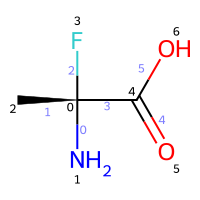

In [4]:
smi = '[C@](N)(C)(F)C(=O)O'
draw_mol(smi)

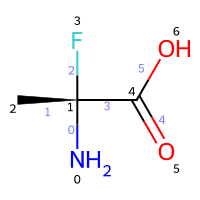

In [5]:
smi = 'N[C@](C)(F)C(=O)O'
draw_mol(smi)

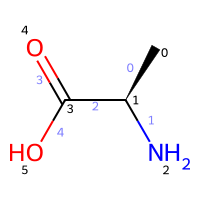

In [6]:
lalanine_smi = kcs.filter(pl.col("name") == "L-alanine")['smiles'][0]
lalanine = Chem.MolFromSmiles(lalanine_smi)
draw_mol(lalanine_smi)

Test of whether can extract fragments w/ tetrahedral centers and still match the molecule where there from

In [7]:
def fragment_chiral_center(mol: Chem.Mol, ctr_idx: int | list[int], radius: int) -> tuple[str, tuple[int]]:
    '''
    Returns SMARTS and atom indices of the fragment consisting of radius hops around the chiral center at ctr_idx.
    '''
    if type(ctr_idx) is int:
        ctr_idx = [ctr_idx]

    atom_idxs = set()
    for idx in ctr_idx:
        bond_idxs = list(Chem.FindAtomEnvironmentOfRadiusN(mol=mol, radius=radius, rootedAtAtom=idx))
        for bond in bond_idxs:
            atom_idxs.add(mol.GetBondWithIdx(bond).GetBeginAtomIdx())
            atom_idxs.add(mol.GetBondWithIdx(bond).GetEndAtomIdx())

    smarts = Chem.MolFragmentToSmarts(mol, atomsToUse=list(atom_idxs))
    return smarts, tuple(sorted(atom_idxs))


In [8]:
def fragment_chiral_center_w_check(mol: Chem.Mol, ctr_idx: int, radius: int) -> tuple[str, tuple[int]]:
    if radius == 0:
        raise ValueError('Radius must be greater than 0 to include any neighbors of the chiral center.')

    chiral_ctr_idxs = set([elt[0] for elt in Chem.FindMolChiralCenters(mol)])
    
    if ctr_idx not in chiral_ctr_idxs:
        raise ValueError(f'Atom index {ctr_idx} is not a chiral center in the given molecule.')
    
    ctrs_covered = set()
    atom_idxs = set()
    missing_ctrs = set([ctr_idx])

    while missing_ctrs:
        ctr_idx = missing_ctrs.pop()
        bond_idxs = list(Chem.FindAtomEnvironmentOfRadiusN(mol=mol, radius=radius, rootedAtAtom=ctr_idx))

        if len(bond_idxs) == 0:
            bond_idxs = [bond.GetIdx() for bond in mol.GetBonds()]

        for bond in bond_idxs:
            atom_idxs.add(mol.GetBondWithIdx(bond).GetBeginAtomIdx())
            atom_idxs.add(mol.GetBondWithIdx(bond).GetEndAtomIdx())

        ctrs_covered.add(ctr_idx)
        missing_ctrs = (atom_idxs & chiral_ctr_idxs) - ctrs_covered


    smarts = Chem.MolFragmentToSmarts(mol, atomsToUse=list(atom_idxs))
    return smarts, tuple(sorted(atom_idxs))

In [9]:
def invert_chiral_centers(mol: Chem.Mol, ctr_idxs: list[int]) -> Chem.Mol:
    mol_copy = deepcopy(mol)
    for idx in ctr_idxs:
        atom = mol_copy.GetAtomWithIdx(idx)
        atom.InvertChirality()
    return mol_copy

In [10]:
fragment_chiral_center_w_check(lalanine, ctr_idx=1, radius=1)

('[#6]-[#6@@H](-[#7])-[#6]', (0, 1, 2, 3))

In [11]:
fragment_chiral_center(lalanine, ctr_idx=1, radius=1)

('[#6]-[#6@@H](-[#7])-[#6]', (0, 1, 2, 3))

In [12]:
max_swaps = 100

for r in range(1, 4):
    print(f"Radius: {r}")
    for row in tqdm(kcs.iter_rows(named=True), total=kcs.height):
        smi = row['smiles']
        mol = Chem.MolFromSmiles(smi)
        chiral_centers = [elt[0] for elt in Chem.FindMolChiralCenters(mol)]
        
        if len(chiral_centers) == 0:
            continue
        for ctr_idx in chiral_centers:
            frag_sma, frag_aidxs = fragment_chiral_center_w_check(mol, ctr_idx=ctr_idx, radius=r)
            frag = Chem.MolFromSmarts(frag_sma)
            matches = mol.GetSubstructMatches(frag, useChirality=True)
            matched = False
            for match in matches:
                if tuple(sorted(match)) == frag_aidxs:
                    matched = True
                    break

            # Don't understand this. Borrowed from rdchiral
            if not matched:
                frag_ctr_idxs = [elt[0] for elt in Chem.FindMolChiralCenters(frag)]
                for i in range(max_swaps):
                    to_invert = int(np.random.choice(frag_ctr_idxs))
                    atom = frag.GetAtomWithIdx(to_invert)
                    atom.InvertChirality()
                    matches = mol.GetSubstructMatches(frag, useChirality=True)
                    for match in matches:
                        if tuple(sorted(match)) == frag_aidxs:
                            matched = True
                            break
                    if matched:
                        break
                
            assert matched, f"Fragment atom indices do not match for {smi} at ctr idx {ctr_idx} w/ radius {r}"

Radius: 1


100%|██████████| 11828/11828 [00:26<00:00, 448.01it/s] 


Radius: 2


100%|██████████| 11828/11828 [00:35<00:00, 331.81it/s] 


Radius: 3


100%|██████████| 11828/11828 [00:48<00:00, 242.64it/s] 


Example of this chiral substructure matching weirdness

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_11276/100102086.py:1: SyntaxWarning: invalid escape sequence '\c'
  smi = 'C=CC1=C(C)/C(=C/C2=N/C(=C3\c4[nH]c(Cc5[nH]c(C=O)c(C)c5CC)c(C)c4C(=O)[C-]3C(=O)OC)[C@@H](CCC(=O)O)[C@@H]2C)NC1=O'


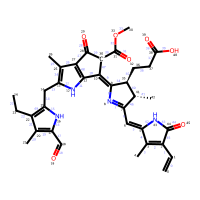

In [13]:
smi = 'C=CC1=C(C)/C(=C/C2=N/C(=C3\c4[nH]c(Cc5[nH]c(C=O)c(C)c5CC)c(C)c4C(=O)[C-]3C(=O)OC)[C@@H](CCC(=O)O)[C@@H]2C)NC1=O'
ctr_idx = 35
radius = 3
mol = Chem.MolFromSmiles(smi)
draw_mol(smi)

[#6]=[#6]/[#6]1=[#7]/[#6](=[#6](\[#6])-[#6-])-[#6@@H](-[#6]-[#6]-[#6])-[#6@@H]-1-[#6]


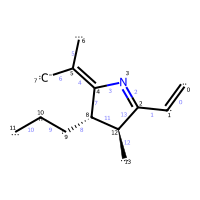

In [14]:
frag_sma, frag_aidxs = fragment_chiral_center_w_check(mol, ctr_idx=ctr_idx, radius=radius)
print(frag_sma)
frag = Chem.MolFromSmarts(frag_sma)
draw_mol(frag_sma)

In [15]:
mol.GetSubstructMatches(frag, useChirality=True), frag_aidxs

((), (5, 6, 7, 8, 9, 10, 11, 30, 35, 36, 37, 38, 41, 42))

In [16]:
frag_centers = [elt[0] for elt in Chem.FindMolChiralCenters(frag)]
frag_centers

[8, 12]

In [17]:
invert_this = int(np.random.choice(frag_centers))
print(invert_this)
atom = frag.GetAtomWithIdx(invert_this)
atom.InvertChirality()
mol.GetSubstructMatches(frag, useChirality=True), frag_aidxs

12


((), (5, 6, 7, 8, 9, 10, 11, 30, 35, 36, 37, 38, 41, 42))

In [18]:
Chem.MolToSmarts(frag)

'[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@@&H1](-[#6]-[#6]-[#6])-[#6@&H1]-1-[#6]'

In [19]:
print(Chem.MolToSmarts(frag))
for idx in frag_centers:
    atom = frag.GetAtomWithIdx(idx)
    atom.InvertChirality()

print(Chem.MolToSmarts(frag))

[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@@&H1](-[#6]-[#6]-[#6])-[#6@&H1]-1-[#6]
[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@&H1](-[#6]-[#6]-[#6])-[#6@@&H1]-1-[#6]


In [20]:
'''
[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@@&H1](-[#6]-[#6]-[#6])-[#6@@&H1]-1-[#6] YES
[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@@&H1](-[#6]-[#6]-[#6])-[#6@@&H1]-1-[#6] NO
[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@&H1](-[#6]-[#6]-[#6])-[#6@&H1]-1-[#6] NO

'''

'\n[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@@&H1](-[#6]-[#6]-[#6])-[#6@@&H1]-1-[#6] YES\n[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@@&H1](-[#6]-[#6]-[#6])-[#6@@&H1]-1-[#6] NO\n[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@&H1](-[#6]-[#6]-[#6])-[#6@&H1]-1-[#6] NO\n\n'

In [21]:
"[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@@&H1](-[#6]-[#6]-[#6])-[#6@@&H1]-1-[#6]" == "[#6]=[#6][#6]1=[#7][#6](=[#6]([#6])-[#6&-])-[#6@@&H1](-[#6]-[#6]-[#6])-[#6@@&H1]-1-[#6]"

True

In [27]:
kcs.filter(
    pl.col("smiles").str.contains("/")
).sort("n_atoms", descending=False)

id,smiles,name,chebi_id,n_atoms
str,str,str,str,i32
"""69c4b9faacbb9f75fd165ea32f32e0…","""*/C=C\*""","""a cis-alkene""","""CHEBI:139021""",4
"""ba2294e040705d59532776e39e6639…","""Cl/C=C\Cl""","""(Z)-1,2-dichloroethene""","""CHEBI:28805""",4
"""8973f8bd19c7e61e439c7581c8d436…","""*/C=C/C=O""","""(2E)-fatty aldehyde""","""CHEBI:84588""",5
"""ccb04f518b5c35d1a27555d79355ed…","""*/C=C/SO""","""(E)-alk-1-en-1-SO-peroxol""","""CHEBI:183056""",5
"""4babcc5e4457c76f5241ccc74c6e95…","""C/C=C/C=O""","""(2E)-but-2-enal""","""CHEBI:41607""",5
…,…,…,…,…
"""946c3628984034c1f4fc44b0dd1103…","""CC(=O)N[C@H]1[C@@H](O[C@@H]2[C…","""[alpha-D-GalNAc-(1->4)]2-[beta…","""CHEBI:68654""",161
"""6725ed8f375a0073143d9c82598d83…","""CCCCCCCCCCCCC/C=C/[C@@H](O)[C@…","""N-acetyl-alpha-neuraminosyl-(2…","""CHEBI:88228""",167
"""82a53ed93500c0f60e471090e80685…","""*C(=O)N[C@@H](CO[C@@H]1O[C@H](…","""a ganglioside GP1c (d18:1(4E))""","""CHEBI:87792""",171


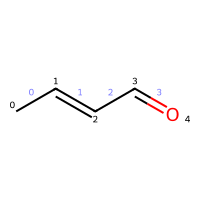

In [29]:
ebutenal_smi = kcs.filter(
    pl.col("name") == "(2E)-but-2-enal"
)['smiles'][0]
ebutenal = Chem.MolFromSmiles(ebutenal_smi)
draw_mol(ebutenal_smi)

In [30]:
for bond in ebutenal.GetBonds():
    print(bond.GetIdx(), bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType(), bond.GetStereo())

0 0 1 SINGLE STEREONONE
1 1 2 DOUBLE STEREOE
2 2 3 SINGLE STEREONONE
3 3 4 DOUBLE STEREONONE


In [50]:
def fragment_stereo_bond_w_check(mol: Chem.Mol, template_idxs: list[int]) -> tuple[str, tuple[int]]:
    '''
    
    '''
    chiral_double_bonds = set()
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE and bond.GetStereo() != Chem.BondStereo.STEREONONE:
            chiral_double_bonds.add(bond.GetIdx())

    double_bonds_covered = set()
    atom_idxs = set(template_idxs)
    missing_bonds = set()
    for bond_idx in chiral_double_bonds:
        bond = mol.GetBondWithIdx(bond_idx)
        if bond.GetBeginAtomIdx() in atom_idxs and bond.GetEndAtomIdx() in atom_idxs:
            missing_bonds.add(bond_idx)

    while missing_bonds:
        bond_idx = missing_bonds.pop()
        bond = mol.GetBondWithIdx(bond_idx)
        begin_atom = mol.GetAtomWithIdx(bond.GetBeginAtomIdx())
        end_atom = mol.GetAtomWithIdx(bond.GetEndAtomIdx())

        # Need all neighbors of atoms in chiral double bond for proper stereo definition
        for neighbor in begin_atom.GetNeighbors():
            atom_idxs.add(neighbor.GetIdx())
        for neighbor in end_atom.GetNeighbors():
            atom_idxs.add(neighbor.GetIdx())
        
        double_bonds_covered.add(bond_idx)
        
        missing_bonds = set()
        for bond_idx in chiral_double_bonds:
            bond = mol.GetBondWithIdx(bond_idx)
            if bond.GetBeginAtomIdx() in atom_idxs and bond.GetEndAtomIdx() in atom_idxs:
                double_bonds_covered.add(bond_idx)

        missing_bonds -= double_bonds_covered

    smarts = Chem.MolFragmentToSmarts(mol, atomsToUse=list(atom_idxs))
    return smarts, tuple(sorted(atom_idxs))

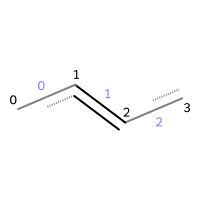

In [51]:
frag_sma, frag_aidxs = fragment_stereo_bond_w_check(ebutenal, template_idxs=[1,2])
frag = Chem.MolFromSmarts(frag_sma)
draw_mol(frag)

In [52]:
for r in range(1, 4):
    print(f"Radius: {r}")
    for row in tqdm(kcs.iter_rows(named=True), total=kcs.height):
        smi = row['smiles']
        mol = Chem.MolFromSmiles(smi)
        
        db_atoms = []
        for bond in mol.GetBonds():
            if bond.GetBondType() == Chem.BondType.DOUBLE and bond.GetStereo() != Chem.BondStereo.STEREONONE:
                db_atoms.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))
        
        if len(db_atoms) == 0:
            continue
        for tmp in db_atoms:
            atom_idxs = set(tmp)
            for aidx in tmp:
                bond_idxs = list(Chem.FindAtomEnvironmentOfRadiusN(mol=mol, radius=radius, rootedAtAtom=aidx))

            if len(bond_idxs) == 0:
                bond_idxs = [bond.GetIdx() for bond in mol.GetBonds()]

            for bond in bond_idxs:
                atom_idxs.add(mol.GetBondWithIdx(bond).GetBeginAtomIdx())
                atom_idxs.add(mol.GetBondWithIdx(bond).GetEndAtomIdx())

            frag_sma, frag_aidxs = fragment_stereo_bond_w_check(mol, template_idxs=list(atom_idxs))
            frag = Chem.MolFromSmarts(frag_sma)
            matches = mol.GetSubstructMatches(frag, useChirality=True)
            matched = False
            for match in matches:
                if tuple(sorted(match)) == frag_aidxs:
                    matched = True
                    break
                
            assert matched, f"Fragment atom indices do not match for {smi} at ctr idx {ctr_idx} w/ radius {r}"

Radius: 1


100%|██████████| 11828/11828 [00:03<00:00, 3056.28it/s]


Radius: 2


100%|██████████| 11828/11828 [00:05<00:00, 2089.29it/s]


Radius: 3


100%|██████████| 11828/11828 [00:05<00:00, 2076.70it/s]
